# Particle Collision Simulation

## import libraries

In [1]:
#import packeges
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sympy import symbols, Eq, solve #equation
from math import isclose

#Import the libraries for neural networks
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Lambda, Dropout, BatchNormalization
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import utils


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

### Define coordinate convertor functions

In [2]:
#plotting setup
plt.rcParams['figure.figsize'] = [9, 4]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 8
# plt.style.use('Solarize_Light2')

In [3]:
# convert cartesian to spherical
def cart_to_spher(x, y, z):
  p = np.sqrt(x**2 + y**2 + z**2)
  theta = np.arccos(z / p)
  phi = np.arctan2(y , x)
  try:
    for i in range(len(phi)):
      if phi[i] < 0:
        phi[i] = phi[i] + 2*np.pi
  except:
    # in case phi is scaler
    if phi < 0:
      phi = phi + 2*np.pi

  return p, theta, phi

# convert spherical to cartesian
def spher_to_cart(p, theta, phi):
  x = p * np.sin(theta) * np.cos(phi)
  y = p * np.sin(theta) * np.sin(phi)
  z = p * np.cos(theta)
  return x, y, z

In [4]:
#sanity check the defined functions
print(spher_to_cart(1,3,6))
cart_to_spher(spher_to_cart(1,3,6)[0],spher_to_cart(1,3,6)[1],spher_to_cart(1,3,6)[2])

(0.13549923859094465, -0.03943111735788423, -0.9899924966004454)


(0.9999999999999999, 3.0000000000000004, 6.0)

# Generating samples (Monte Carlo simulation)

In [5]:
nr_instance = 100000
nr_features = 10
E_init = 200
E_total = 2*E_init
np.random.seed(42)
X       = np.zeros((nr_instance, nr_features)) # main sample array
X_smear = np.zeros((nr_instance, nr_features)) # main smeared sample array

st = time.time()
miss_cnt = 0
for i in tqdm(range(nr_instance)):

  # before smear
  # Monte Carlo Sampling
  while(True):
    # sampling for mass 1 and 2
    M_1 = np.random.uniform(10, 150)
    M_2 = np.random.uniform(10, 150)
    
    #sample particle 1 in spherical coordinate
    theta_1 = np.pi * np.random.uniform(0, 1)
    phi_1 = 2*np.pi * np.random.uniform(0, 1)
    P_1 = np.random.uniform(0, E_total)

    #convert to cartesian 
    p_x1, p_y1, p_z1 = spher_to_cart(P_1, theta_1, phi_1)

    # calculate Energy for particle 1
    E_1 = np.sqrt(P_1**2 + M_1**2)

    # calculate Energy for particle 2 (Rest of energy)
    E_2 = E_total - E_1

    # particle 2 setup
    theta_2 = np.pi - theta_1
    phi_2 = (np.pi + phi_1) % (2*np.pi)
    
    P_2 = np.sqrt(E_2**2 - M_2**2) # sqrt(px2 + py2 + px2)
    p_x2, p_y2, p_z2 = spher_to_cart(P_2, theta_2, phi_2)
    
    # check some condition to keep the formula conserved
    if E_1 >= E_total or np.isnan(P_2):
      miss_cnt += 1
    else:
      break

  if np.random.rand() > 0.5:
    P_1,E_1, p_x1, p_y1, p_z1,M_1, P_2,E_2, p_x2, p_y2, p_z2,M_2 = P_2,E_2, p_x2, p_y2, p_z2, M_2, P_1,E_1, p_x1, p_y1, p_z1,M_1
    
  X[i,0] = E_1
  X[i,5] = E_2
  X[i,1] = p_x1
  X[i,2] = p_y1
  X[i,3] = p_z1
  X[i,6] = p_x2
  X[i,7] = p_y2
  X[i,8] = p_z2
  X[i,4] = M_1
  X[i,9] = M_2

  #smearing setup (10% for energy and 5% for each angel)
  #particle 1
  while True:
    #energy smearing
    E_smear1 = E_1 * np.random.normal(1 , 0.1)
    X_smear[i,0] = E_smear1
    #momentum smearing
    theta_1_smear = theta_1 * np.random.normal(1 , 0.05) 
    phi_1_smear = phi_1 * np.random.normal(1 , 0.05)
    
    p_x1, p_y1, p_z1 = spher_to_cart(P_1, theta_1_smear, phi_1_smear)
    
    if p_x1**2 + p_y1**2 + p_z1**2 < E_smear1**2:
      break
  X_smear[i,1] = p_x1
  X_smear[i,2] = p_y1
  X_smear[i,3] = p_z1

  M_smear1 = np.sqrt((E_smear1**2) - (p_x1**2 + p_y1**2 + p_z1**2))
  X_smear[i,4] = M_smear1

  # particle2
  while True:
    #energy smearing
    E_smear2 = E_2 * np.random.normal(1 , 0.1)
    X_smear[i,5] = E_smear2
    #momentum smearing
    theta_2_smear = theta_2 * np.random.normal(1 , 0.05) 
    phi_2_smear = phi_2 * np.random.normal(1 , 0.05)
    
    p_x2, p_y2, p_z2 = spher_to_cart(P_2, theta_2_smear, phi_2_smear)
    if p_x2**2 + p_y2**2 + p_z2**2 < E_smear2**2:
      break
  X_smear[i,6] = p_x2
  X_smear[i,7] = p_y2
  X_smear[i,8] = p_z2

  M_smear2 = np.sqrt((E_smear2**2) - (p_x2**2 + p_y2**2 + p_z2**2))
  X_smear[i,9] = M_smear2

et = time.time()
# get the execution time
elapsed_time = et - st
print('Execution time:', round(elapsed_time, 2), 'sec')

  0%|          | 0/100000 [00:00<?, ?it/s]

Execution time: 25.11 sec


## Print hit rate (1 - rejection rate) of sampling

In [6]:
print('hit rate: ', nr_instance/(miss_cnt+nr_instance) * 100)

hit rate:  76.5515076819438


## Check if the equation before and after smear holds

In [7]:
#particel1
cnt = 0
for i in range(100):
  if not isclose(X_smear[i,0]**2, (X_smear[i,1]**2+X_smear[i,2]**2+X_smear[i,3]**2+X_smear[i,4]**2)):
    cnt += 1
if cnt == 0:
  print('Particle 1 -> OK!')
else:
  print('Particle 1 fail ',str(cnt))

#particel2
cnt = 0
for i in range(100):
  if not isclose(X_smear[i,5]**2, (X_smear[i,6]**2+X_smear[i,7]**2+X_smear[i,8]**2+X_smear[i,9]**2)):
    cnt += 1
if cnt == 0:
  print('Particle 2 -> OK!')
else:
  print('Particle 2 fail ',str(cnt)) 

Particle 1 -> OK!
Particle 2 -> OK!


## Convert to dataframe

In [8]:
X_smeared_df = pd.DataFrame(X_smear)
X_smeared_df.head()

,0,1,2,3,4,5,6,7,8,9
0,102.218263,-36.815302,-21.649593,-45.504057,80.956055,328.635438,166.869327,115.502661,188.433385,176.940311
1,259.733284,-54.542212,230.489081,61.629255,86.966342,140.665674,29.191186,-111.665024,-45.976088,65.968388
2,245.410900,-79.640318,-142.825265,172.401470,61.340087,134.833725,46.852237,75.475785,-87.489891,51.321791
3,295.662047,-95.354640,129.120746,-212.339947,128.697780,133.817346,30.990370,-51.491949,94.952872,72.658174
4,179.925341,8.326684,-114.958706,-112.022798,80.865218,254.691410,-5.725962,174.552361,141.080903,120.260465


### Plot Energy histogram (before/after smear)

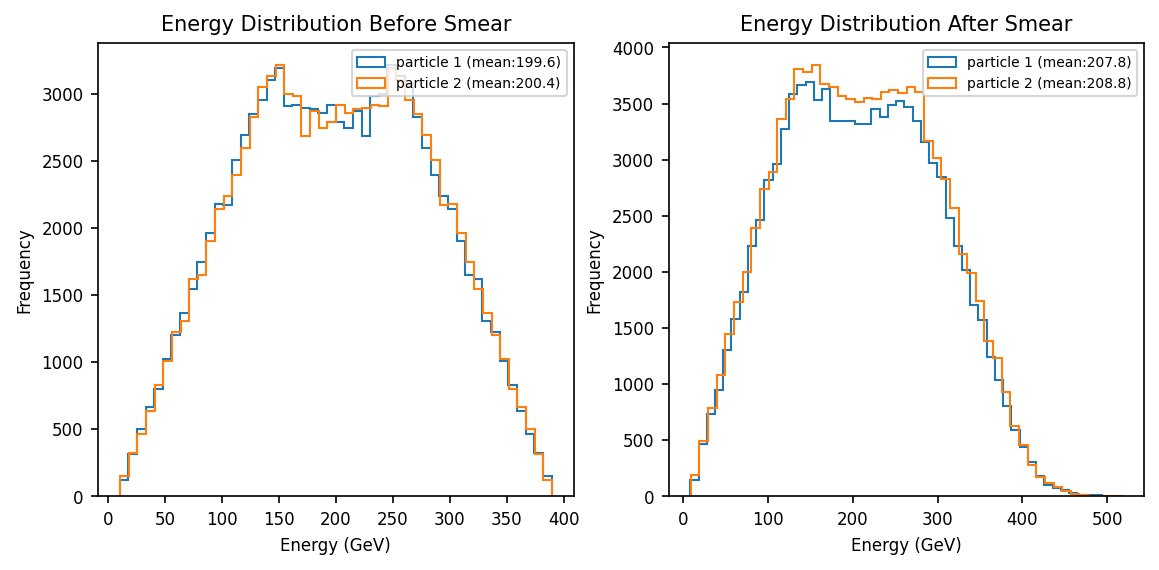

In [9]:
plt.figure()
plt.subplot(1,2,1)
plt.hist(X[:,0], bins=50,  histtype='step', stacked=True,
         label='particle 1 (mean:'+str(np.round(np.mean(X[:,0]), 1))+')');
plt.hist(X[:,5], bins=50,  histtype='step', stacked=True,
         label='particle 2 (mean:'+str(np.round(np.mean(X[:,5]), 1))+')');
plt.xlabel('Energy (GeV)', fontsize=8)
plt.ylabel('Frequency', fontsize=8)
plt.legend(fontsize='small')
plt.title('Energy Distribution Before Smear', fontsize=10)
plt.subplot(1,2,2)
plt.hist(X_smear[:,0], bins=50, histtype='step', stacked=True,
         label='particle 1 (mean:'+str(np.round(np.mean(X_smear[:,0]), 1))+')');
plt.hist(X_smear[:,5], bins=50, histtype='step', stacked=True,
         label='particle 2 (mean:'+str(np.round(np.mean(X_smear[:,5]), 1))+')');
plt.xlabel('Energy (GeV)', fontsize=8)
plt.ylabel('Frequency', fontsize=8)
plt.legend(fontsize='small')
plt.title('Energy Distribution After Smear', fontsize=10)
plt.show()

### Energy histogram (after smear)

### Mass histogram before/after smearing 

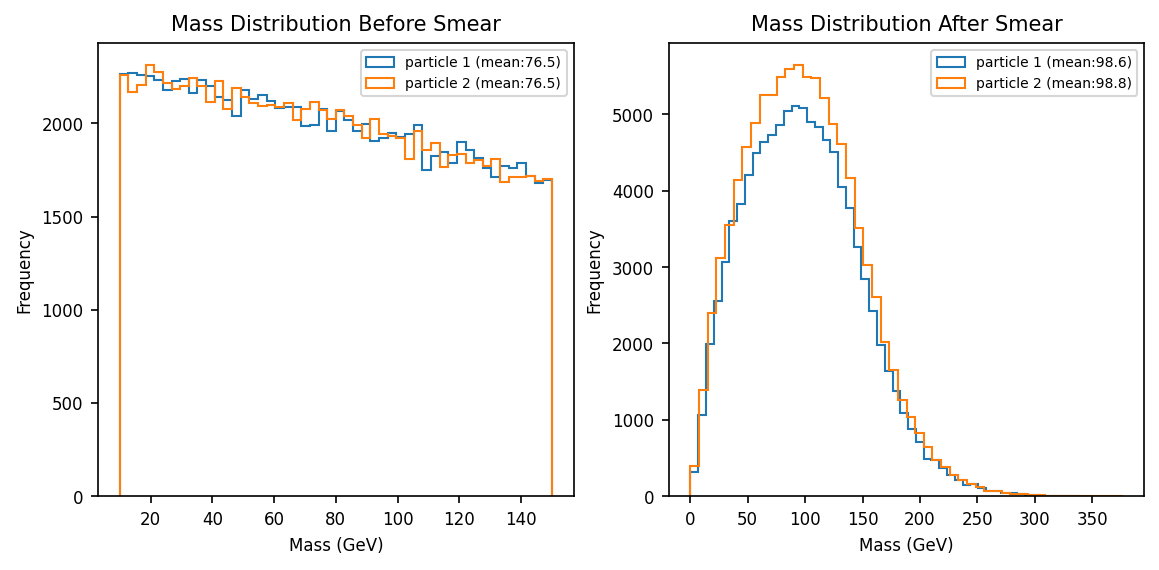

In [10]:
plt.figure()
plt.subplot(1,2,1)
plt.hist(X[:,4], bins=50,  histtype='step', stacked=True,
         label='particle 1 (mean:'+str(np.round(np.mean(X[:,4]), 1))+')');
plt.hist(X[:,9], bins=50,  histtype='step', stacked=True,
         label='particle 2 (mean:'+str(np.round(np.mean(X[:,9]), 1))+')');
plt.xlabel('Mass (GeV)', fontsize=8)
plt.ylabel('Frequency', fontsize=8)
plt.legend(fontsize='small')
plt.title('Mass Distribution Before Smear', fontsize=10)
plt.subplot(1,2,2)
plt.hist(X_smear[:,4], bins=50, histtype='step', stacked=True,
         label='particle 1 (mean:'+str(np.round(np.mean(X_smear[:,4]), 1))+')');
plt.hist(X_smear[:,9], bins=50, histtype='step', stacked=True,
         label='particle 2 (mean:'+str(np.round(np.mean(X_smear[:,9]), 1))+')');
plt.xlabel('Mass (GeV)', fontsize=8)
plt.ylabel('Frequency', fontsize=8)
plt.legend(fontsize='small')
plt.title('Mass Distribution After Smear', fontsize=10)
plt.show()

### ϕ,  θ histograms

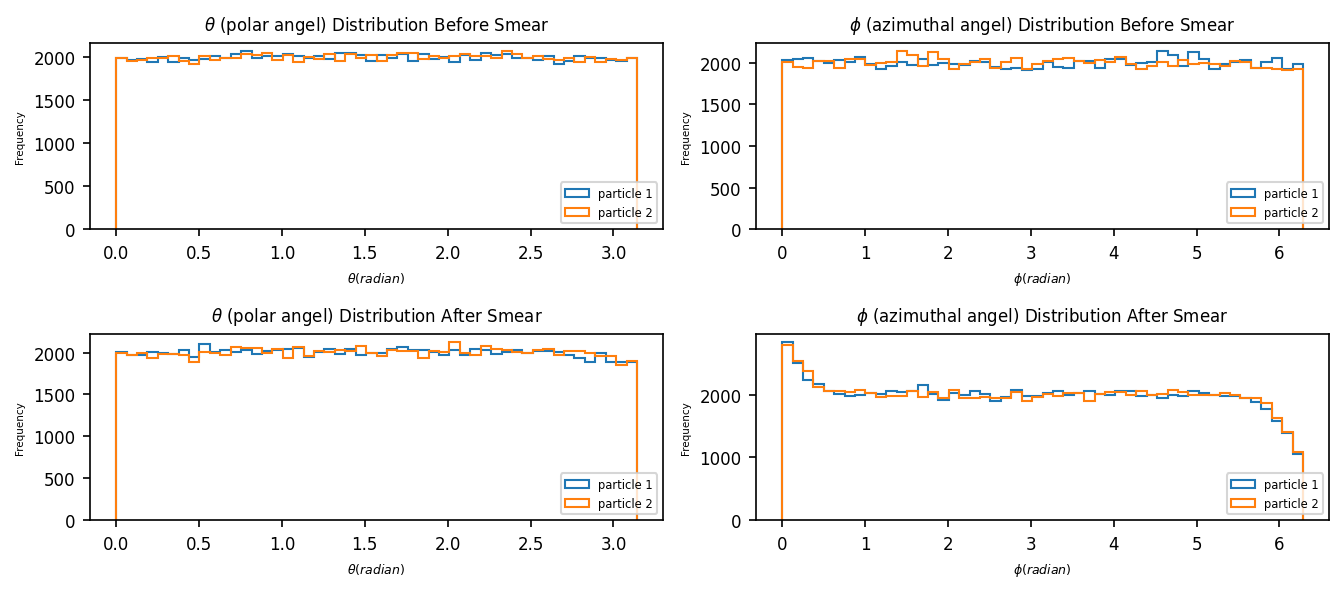

In [11]:
fig = plt.figure()
#before smear tetha/phi both particles
plt.subplot(2,2,1)
plt.hist(cart_to_spher(X[:,1],X[:,2],X[:,3])[1], bins=50,  histtype='step', stacked=True,
         label='particle 1');
plt.hist(cart_to_spher(X[:,6],X[:,7],X[:,8])[1], bins=50,  histtype='step', stacked=True,
         label='particle 2');
plt.xlabel('$\\theta (radian)$', fontsize=6)
plt.ylabel('Frequency', fontsize=5)
plt.legend(fontsize='x-small', loc=4)
plt.title('$\\theta$ (polar angel) Distribution Before Smear', fontsize=8)
plt.subplot(2,2,2)
plt.hist(cart_to_spher(X[:,1],X[:,2],X[:,3])[2], bins=50, histtype='step', stacked=True,
         label='particle 1');
plt.hist(cart_to_spher(X[:,6],X[:,7],X[:,8])[2], bins=50, histtype='step', stacked=True,
         label='particle 2');
plt.xlabel('$\phi (radian)$', fontsize=6)
plt.ylabel('Frequency', fontsize=5)
plt.legend(fontsize='x-small', loc=4)
plt.title('$\phi$ (azimuthal angel) Distribution Before Smear', fontsize=8)

plt.subplot(2,2,3)
plt.hist(cart_to_spher(X_smear[:,1],X_smear[:,2],X_smear[:,3])[1], bins=50,  histtype='step', stacked=True,
         label='particle 1');
plt.hist(cart_to_spher(X_smear[:,6],X_smear[:,7],X_smear[:,8])[1], bins=50,  histtype='step', stacked=True,
         label='particle 2');
plt.xlabel('$\\theta (radian)$', fontsize=6)
plt.ylabel('Frequency', fontsize=5)
plt.legend(fontsize='x-small', loc=4)
plt.title('$\\theta$ (polar angel) Distribution After Smear', fontsize=8)
plt.subplot(2,2,4)
plt.hist(cart_to_spher(X_smear[:,1],X_smear[:,2],X_smear[:,3])[2], bins=50, histtype='step', stacked=True,
         label='particle 1');
plt.hist(cart_to_spher(X_smear[:,6],X_smear[:,7],X_smear[:,8])[2], bins=50, histtype='step', stacked=True,
         label='particle 2');
plt.xlabel('$\phi (radian)$', fontsize=6)
plt.ylabel('Frequency', fontsize=5)
plt.legend(fontsize='x-small', loc=4)
plt.title('$\phi$ (azimuthal angel) Distribution After Smear', fontsize=8)

plt.tight_layout()
plt.show()

### Momentum histogram

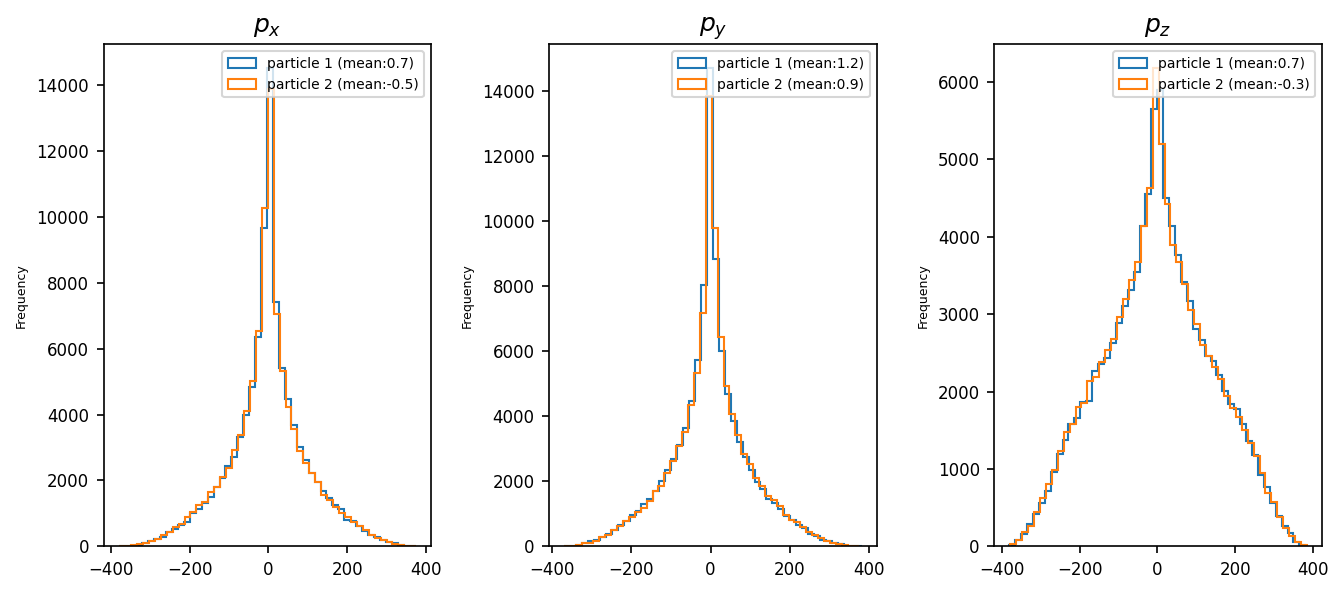

In [12]:
#momentum histograms
# plt.figure(figsize=(10,4), dpi=150)
plt.figure()
plt.subplot(1,3,1)
plt.hist(X[:,1], bins=50,  histtype='step', stacked=True,
         label='particle 1 (mean:'+str(np.round(np.mean(X[:,1]), 1))+')');
plt.hist(X[:,6], bins=50,  histtype='step', stacked=True,
         label='particle 2 (mean:'+str(np.round(np.mean(X[:,6]), 1))+')');
# plt.xlabel('momentum', fontsize=8)
plt.ylabel('Frequency', fontsize=6)
plt.legend(fontsize='small')
plt.title('$p_x$', fontsize=12)

plt.subplot(1,3,2)
plt.hist(X[:,2], bins=50, histtype='step', stacked=True,
         label='particle 1 (mean:'+str(np.round(np.mean(X_smear[:,2]), 1))+')');
plt.hist(X[:,7], bins=50, histtype='step', stacked=True,
         label='particle 2 (mean:'+str(np.round(np.mean(X_smear[:,7]), 1))+')');
# plt.xlabel('momentum', fontsize=8)
plt.ylabel('Frequency', fontsize=6)
plt.legend(fontsize='small')
plt.title('$p_y$', fontsize=12)

plt.subplot(1,3,3)
plt.hist(X[:,3], bins=50, histtype='step', stacked=True,
         label='particle 1 (mean:'+str(np.round(np.mean(X_smear[:,3]), 1))+')');
plt.hist(X[:,8], bins=50, histtype='step', stacked=True,
         label='particle 2 (mean:'+str(np.round(np.mean(X_smear[:,8]), 1))+')');
# plt.xlabel('momentum', fontsize=8)
plt.ylabel('Frequency', fontsize=6)
plt.legend(fontsize='small')
plt.title('$p_z$', fontsize=12)
plt.tight_layout()
plt.show()

### Relativistic relativistic dispersion 

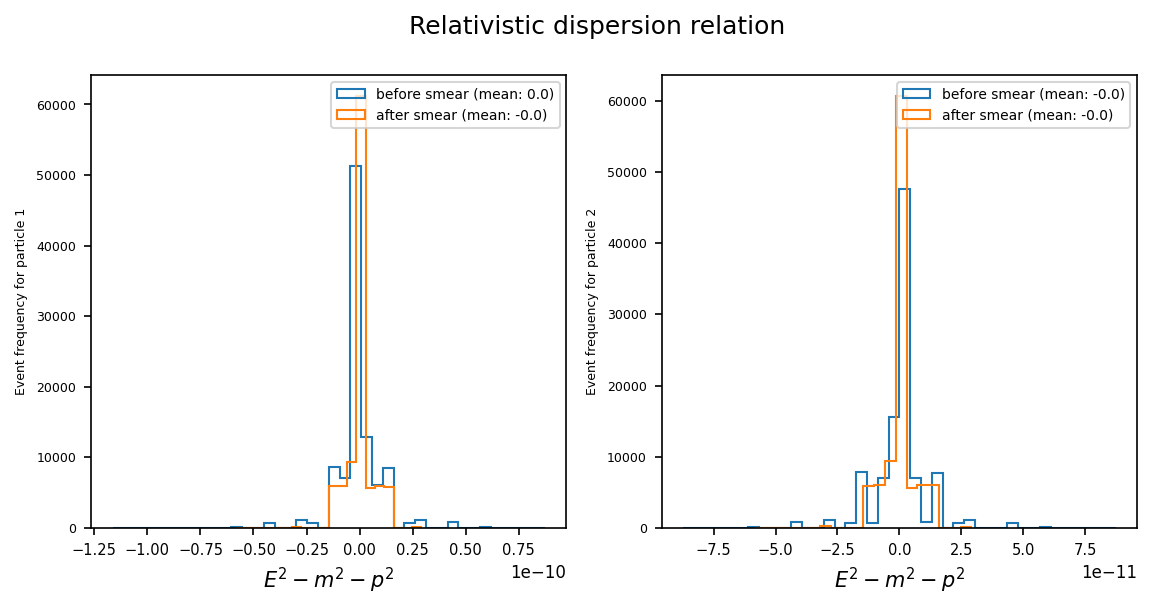

In [13]:
P1 = np.sqrt(X[:, 1]**2 + X[:, 2]**2 + X[:, 3]**2)
P2 = np.sqrt(X[:, 6]**2 + X[:, 7]**2 + X[:, 8]**2)
P1_s = np.sqrt(X_smear[:, 1]**2 + X_smear[:, 2]**2 + X_smear[:, 3]**2)
P2_s = np.sqrt(X_smear[:, 6]**2 + X_smear[:, 7]**2 + X_smear[:, 8]**2)

fig, ax = plt.subplots()
plt.subplot(1,2,1)
plt.hist(X[:, 0]**2 - X[:, 4]**2 - P1**2 , histtype='step', stacked=True,
         label='before smear (mean: ' + str(np.round(np.mean(X[:, 0]**2 - X[:, 4]**2 - P1**2), 2)) + ')', bins=40)
plt.hist(X_smear[:, 0]**2 - X_smear[:, 4]**2 - P1_s**2 , histtype='step',
         label='after smear (mean: ' + str(np.round(np.mean(X_smear[:, 0]**2 - X_smear[:, 4]**2 - P1_s**2), 2)) + ')', stacked=True, bins=20)
plt.xlabel('$E^2 - m^2 - p^2$', fontsize=10)
plt.ylabel('Event frequency for particle 1', fontsize=6)
plt.xticks(fontsize=7)
plt.yticks(fontsize=6)
plt.legend(fontsize='small')
plt.subplot(1,2,2)
plt.hist(X[:, 5]**2 - X[:, 9]**2 - P2**2, histtype='step',
         label='before smear (mean: ' + str(np.round(np.mean(X[:, 5]**2 - X[:, 9]**2 - P2**2), 2)) + ')', stacked=True, bins=40)
plt.hist(X_smear[:, 5]**2 - X_smear[:, 9]**2 - P2_s**2,
         label='after smear (mean: ' + str(np.round(np.mean(X_smear[:, 5]**2 - X_smear[:, 9]**2 - P2_s**2), 2)) + ')', histtype='step', stacked=True, bins=20)
plt.xlabel('$E^2 - m^2 - p^2$', fontsize=10)
plt.ylabel('Event frequency for particle 2', fontsize=6)
plt.xticks(fontsize=7)
plt.yticks(fontsize=6)
plt.legend(fontsize='small')
fig.suptitle('Relativistic dispersion relation', fontsize=12)
plt.show()

## Create dataset and save

In [14]:
pd.DataFrame(X, columns=['E1', 'p_x1', 'p_y1', 'p_z1', 'm1',
                              'E2', 'p_x2', 'p_y2', 'p_z2', 'm2']).describe().T

,count,mean,std,min,25%,50%,75%,max
E1,100000.0,199.612362,82.669516,10.191297,135.243299,199.195483,263.856177,389.466443
p_x1,100000.0,0.732866,98.920493,-380.005411,-47.216977,0.089192,48.874533,372.795556
p_y1,100000.0,-0.591904,99.636535,-370.284009,-48.880490,-0.069502,47.791566,381.807668
p_z1,100000.0,-0.106039,139.617464,-381.799879,-93.787867,0.145720,93.272054,380.876297
m1,100000.0,76.536021,40.190586,10.000071,41.432178,74.885115,110.678519,149.998785
E2,100000.0,200.387638,82.669516,10.533557,136.143823,200.804517,264.756701,389.808703
p_x2,100000.0,-0.523355,99.709696,-378.385029,-48.944825,-0.084828,47.926744,374.440172
p_y2,100000.0,0.713753,99.560625,-370.768560,-48.075523,0.095668,49.774206,376.327445
p_z2,100000.0,-0.348859,140.291442,-379.400131,-95.366439,-0.118044,94.031446,385.309163
m2,100000.0,76.459985,40.084070,10.003375,41.563193,74.801572,110.364189,149.999764


In [15]:
df = pd.DataFrame(X_smear, columns=['E1', 'p_x1', 'p_y1', 'p_z1', 'm1',
                                    'E2', 'p_x2', 'p_y2', 'p_z2', 'm2'])

df.insert(0, 'event_id', range(1, 1 + len(df)))
df.to_csv('./generated_dataset.csv', index=False)

In [16]:
np.round(df.head(5), 2)

,event_id,E1,p_x1,p_y1,p_z1,m1,E2,p_x2,p_y2,p_z2,m2
0,1,102.22,-36.82,-21.65,-45.50,80.96,328.64,166.87,115.50,188.43,176.94
1,2,259.73,-54.54,230.49,61.63,86.97,140.67,29.19,-111.67,-45.98,65.97
2,3,245.41,-79.64,-142.83,172.40,61.34,134.83,46.85,75.48,-87.49,51.32
3,4,295.66,-95.35,129.12,-212.34,128.70,133.82,30.99,-51.49,94.95,72.66
4,5,179.93,8.33,-114.96,-112.02,80.87,254.69,-5.73,174.55,141.08,120.26


In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
event_id,100000.0,50000.500000,28867.657797,1.000000,25000.750000,50000.500000,75000.250000,100000.000000
E1,100000.0,207.835633,90.243140,8.377274,136.353270,205.744716,276.709059,493.780420
p_x1,100000.0,-0.748020,98.905646,-366.563356,-48.962497,-0.163869,47.390322,376.629490
p_y1,100000.0,1.245583,99.842954,-377.099234,-47.314886,1.222085,49.794412,371.329882
p_z1,100000.0,0.688440,139.474410,-381.392744,-92.533494,0.403441,94.196904,381.800008
m1,100000.0,98.591226,49.121697,0.231675,60.956927,95.606938,131.121717,338.458090
E2,100000.0,208.752463,90.240630,8.886641,137.461499,206.793596,277.770527,518.284191
p_x2,100000.0,0.055364,99.773771,-378.454042,-48.543810,0.036797,49.124214,375.850657
p_y2,100000.0,0.912190,99.747120,-372.579810,-48.544739,1.064712,50.177818,374.174158
p_z2,100000.0,-0.316756,140.113191,-381.560385,-95.398104,0.025273,93.930554,385.405970


In [18]:
df.shape

(100000, 11)

# Train the regression model to predict Mass

## Design a MLP regression network as a  regressor

In [19]:
##define input layer
input_layer = Input(shape=(8,), name='input_layer')

##Defining 2 hidden layers
Layer_1 = Dense(16, activation="relu", name='Layer_1')(input_layer)
Layer_2 = Dense(128, activation="relu", name='Layer_2')(Layer_1)
Layer_3 = Dense(16, activation="relu", name='Layer_3')(Layer_2)

##Defining  output layer y1
output = Dense(2, activation="linear", name='output')(Layer_3)

##Defining the model by specifying the input and output layers
model = Model(inputs=input_layer, outputs=output)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 8)]               0         
                                                                 
 Layer_1 (Dense)             (None, 16)                144       
                                                                 
 Layer_2 (Dense)             (None, 128)               2176      
                                                                 
 Layer_3 (Dense)             (None, 16)                2064      
                                                                 
 output (Dense)              (None, 2)                 34        
                                                                 
Total params: 4,418
Trainable params: 4,418
Non-trainable params: 0
_________________________________________________________________


## Plot model architecture

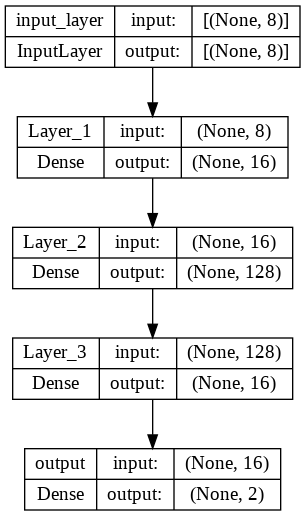

In [21]:
utils.plot_model(model, show_shapes=True)

## Compile and train the regression model

In [22]:
## defining the optimiser and loss function
adam = optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=adam, loss='mean_squared_error')


label = X_smear[:, [4,9]]
data = X_smear[:, [0,1,2,3, 5,6,7,8]]
X_train, X_val, y_train, y_val = train_test_split(data, label, test_size=0.50)
##training the model
history = model.fit(X_train, y_train, epochs=100, verbose=True,
                    batch_size=1024, validation_data=(X_val, y_val))

Epoch 1/100
49/49 [==============================] - 3s 9ms/step - loss: 2076.5779 - val_loss: 1332.9280
Epoch 2/100
49/49 [==============================] - 0s 7ms/step - loss: 1089.7660 - val_loss: 907.2852
Epoch 3/100
49/49 [==============================] - 0s 5ms/step - loss: 792.1688 - val_loss: 689.5569
Epoch 4/100
49/49 [==============================] - 0s 6ms/step - loss: 597.6131 - val_loss: 507.8670
Epoch 5/100
49/49 [==============================] - 0s 7ms/step - loss: 454.3784 - val_loss: 399.8351
Epoch 6/100
49/49 [==============================] - 0s 6ms/step - loss: 355.5132 - val_loss: 318.4726
Epoch 7/100
49/49 [==============================] - 0s 6ms/step - loss: 296.6384 - val_loss: 294.8444
Epoch 8/100
49/49 [==============================] - 0s 6ms/step - loss: 257.3742 - val_loss: 236.4959
Epoch 9/100
49/49 [==============================] - 0s 5ms/step - loss: 230.6747 - val_loss: 231.1196
Epoch 10/100
49/49 [==============================] - 0s 6ms/step - lo

## Plot train & validation losses

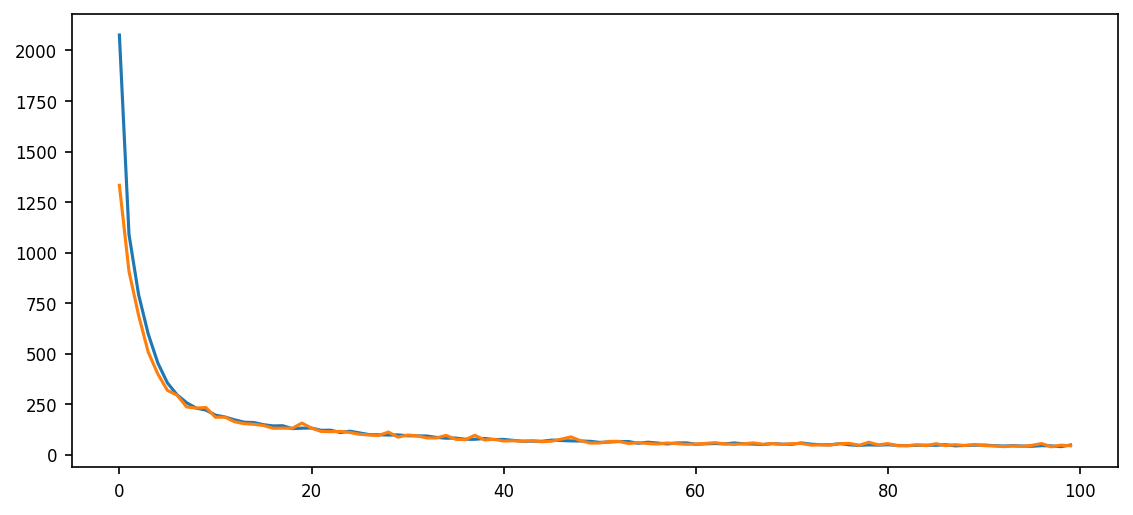

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

## Calculate RMSE on test data as a measure of uncertainty of the prediction.

In [24]:
y_pred = model.predict(X_val)
rmse_m1 = np.sqrt(np.mean((y_val[:,0] - y_pred[:,0])**2))
rmse_m2 = np.sqrt(np.mean((y_val[:,1] - y_pred[:,1])**2))

print('rmse of M1: ', rmse_m1) #this means it could predict the mass with tolernace rmse
print('rmse of M2: ', rmse_m2)

1563/1563 [==============================] - 2s 1ms/step
rmse of M1:  7.120653059642746
rmse of M2:  6.148058353351342


## Scatter plots of Actual vs Predicted labels to interpret regression model

Text(0, 0.5, 'predicted label')

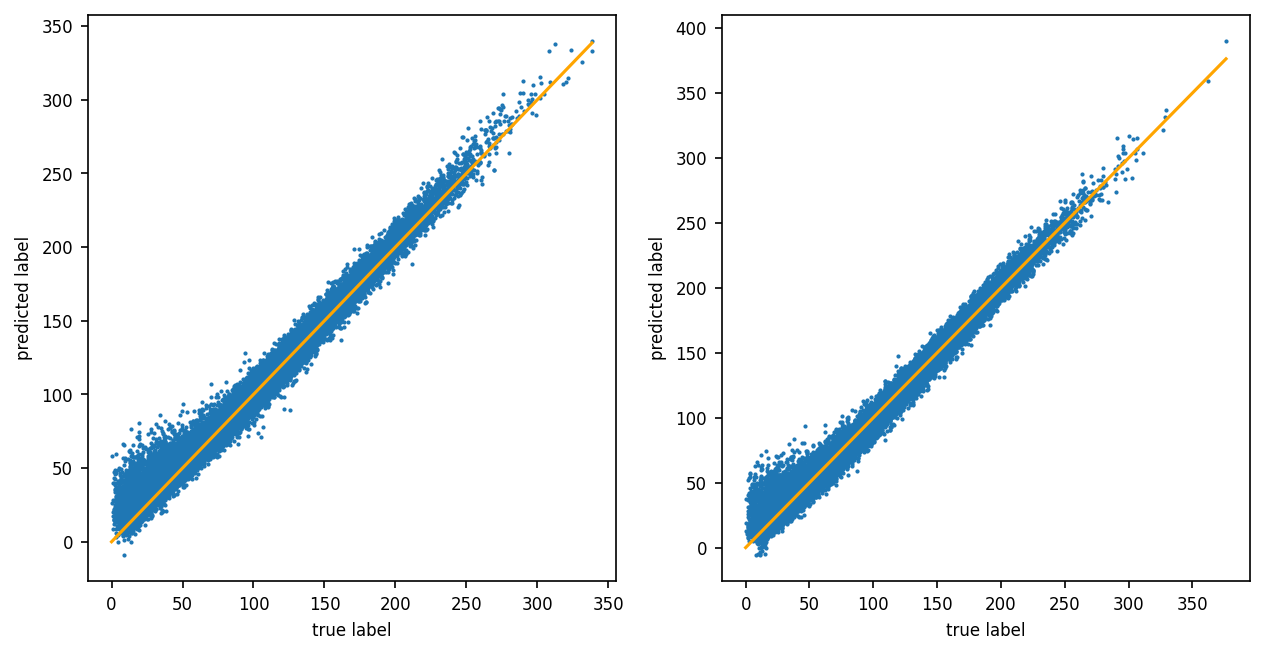

In [25]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(y_val[:,0], y_pred[:,0], s=1)
plt.plot((0,np.max(y_val[:,0])), (0,np.max(y_val[:,0])), c='orange')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.subplot(122)
plt.scatter(y_val[:,1], y_pred[:,1], s=1)
plt.plot((0,np.max(y_val[:,1])), (0,np.max(y_val[:,1])), c='orange')
plt.xlabel('true label')
plt.ylabel('predicted label')

# Generative model for simulation

# VAE design

In [56]:
# Shape of an individual datapoint that will serve as input to our network
input_shape = (2,)

# Properties of the hidden layer of the encoder
size_encoder_hidden = 64
activation_encoder_hidden = 'sigmoid'

# Properties of the latent space
size_latent = 2

In [57]:
encoder_inputs = Input(shape=input_shape, name="encoder_input")
encoder_hidden1 = Dense(size_encoder_hidden, activation=activation_encoder_hidden,
                        name="encoder_hidden1")(encoder_inputs)
z_mean = Dense(size_latent, activation='linear', name="mean")(encoder_hidden1)
z_log_var = Dense(size_latent, activation='linear', name="logvariance")(encoder_hidden1)

In [58]:
def sample(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sample, output_shape=(size_latent,), name="z")([z_mean, z_log_var])

In [59]:
decoder_disired  = Input(shape=(nr_features-2,), name="decoder_disired")
encoder = Model([encoder_inputs, decoder_disired], [z_mean, z_log_var, z], name="encoder")

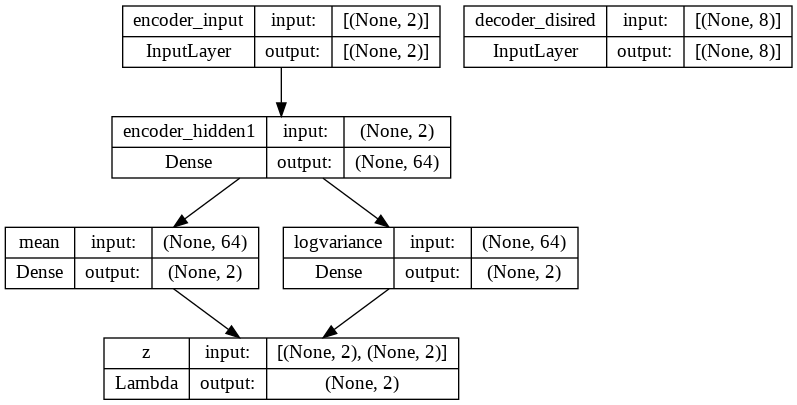

In [60]:
utils.plot_model(encoder, show_shapes=True)

In [61]:
decoder_inputs  = Input(shape=(size_latent,), name="decoder_inputs")
decoder_hidden3 = Dense(size_encoder_hidden, activation=activation_encoder_hidden, name="decoder_hidden3")(decoder_inputs)
decoder_output = Dense(nr_features-2, activation="linear", name="decoder_outputs")(decoder_hidden3)

In [62]:
decoder = Model(decoder_inputs, decoder_output, name="decoder")

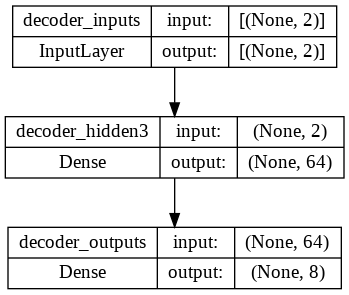

In [63]:
utils.plot_model(decoder, show_shapes=True)

In [64]:
outputs = decoder(encoder([encoder_inputs, decoder_disired])[2])
vae = Model([encoder_inputs, decoder_disired], outputs, name="vae")

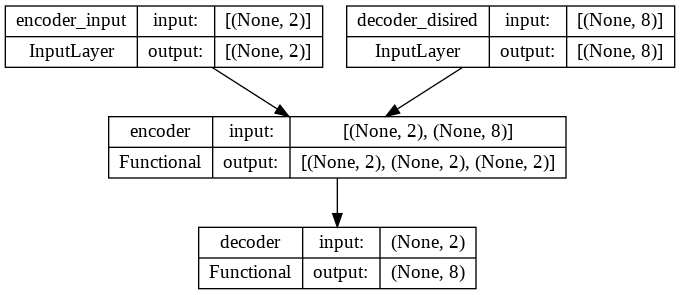

In [65]:
utils.plot_model(vae, show_shapes=True)

In [66]:
reconstruction_loss = mse(decoder_disired, outputs) #mse(encoder_inputs, outputs)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var))
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
alpha = 10e-7
vae_loss = K.mean(reconstruction_loss + alpha * kl_loss)

In [67]:
vae.add_loss(vae_loss)
opt = optimizers.Adam(learning_rate=0.0001)
vae.compile(optimizer=opt, metrics=None)

In [68]:
sk = StandardScaler()
X_val_normal = sk.fit_transform(X_val)

In [69]:
result = vae.fit([y_pred, X_val_normal], validation_split=0.2, epochs=100, batch_size=256)
# result = vae.fit([y_train, X_train], validation_split=0.2, epochs=200, batch_size=512)

Epoch 1/100
157/157 [==============================] - 2s 6ms/step - loss: 1.3580 - val_loss: 1.2028
Epoch 2/100
157/157 [==============================] - 1s 6ms/step - loss: 1.1195 - val_loss: 1.0531
Epoch 3/100
157/157 [==============================] - 1s 6ms/step - loss: 1.0222 - val_loss: 0.9983
Epoch 4/100
157/157 [==============================] - 1s 6ms/step - loss: 0.9868 - val_loss: 0.9746
Epoch 5/100
157/157 [==============================] - 1s 4ms/step - loss: 0.9622 - val_loss: 0.9492
Epoch 6/100
157/157 [==============================] - 1s 4ms/step - loss: 0.9401 - val_loss: 0.9312
Epoch 7/100
157/157 [==============================] - 1s 4ms/step - loss: 0.9245 - val_loss: 0.9177
Epoch 8/100
157/157 [==============================] - 1s 5ms/step - loss: 0.9117 - val_loss: 0.9051
Epoch 9/100
157/157 [==============================] - 1s 5ms/step - loss: 0.9025 - val_loss: 0.8975
Epoch 10/100
157/157 [==============================] - 1s 4ms/step - loss: 0.8947 - val_lo

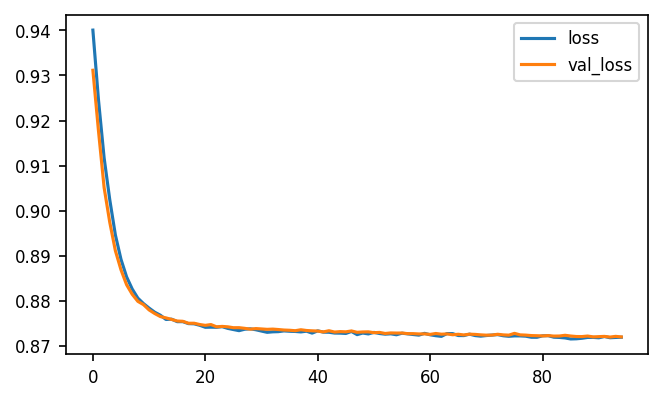

In [70]:
plt.figure(figsize=(5,3))
plt.plot(result.history['loss'][5:])
plt.plot(result.history['val_loss'][5:])
plt.legend(result.history)

## Sampling with VAE

In [71]:
X_val_normal = sk.transform(X_val)

samples_from_latent_space = encoder.predict([y_pred,X_val_normal])[2]
X_fake_normal = decoder.predict(samples_from_latent_space)

1563/1563 [==============================] - 2s 1ms/step


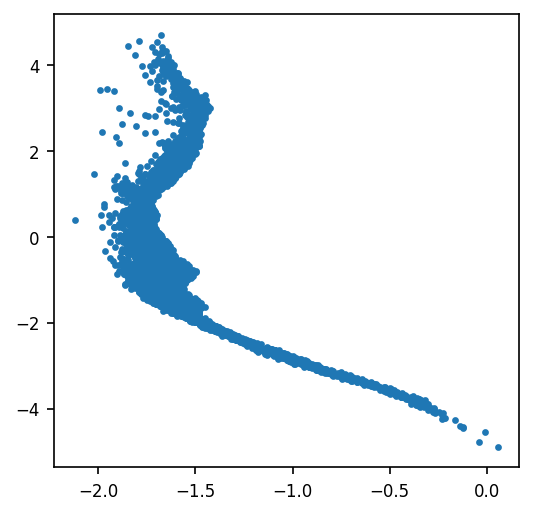

In [72]:
plt.figure(figsize=(4,4))
plt.scatter(samples_from_latent_space[:10000,0],samples_from_latent_space[:10000,1],s=5)

In [73]:
X_fake = sk.inverse_transform(X_fake_normal)



## Use regression network to obtain masses

In [74]:
fake_mass = model.predict(X_fake) 

1563/1563 [==============================] - 2s 2ms/step


## Disperssion relation

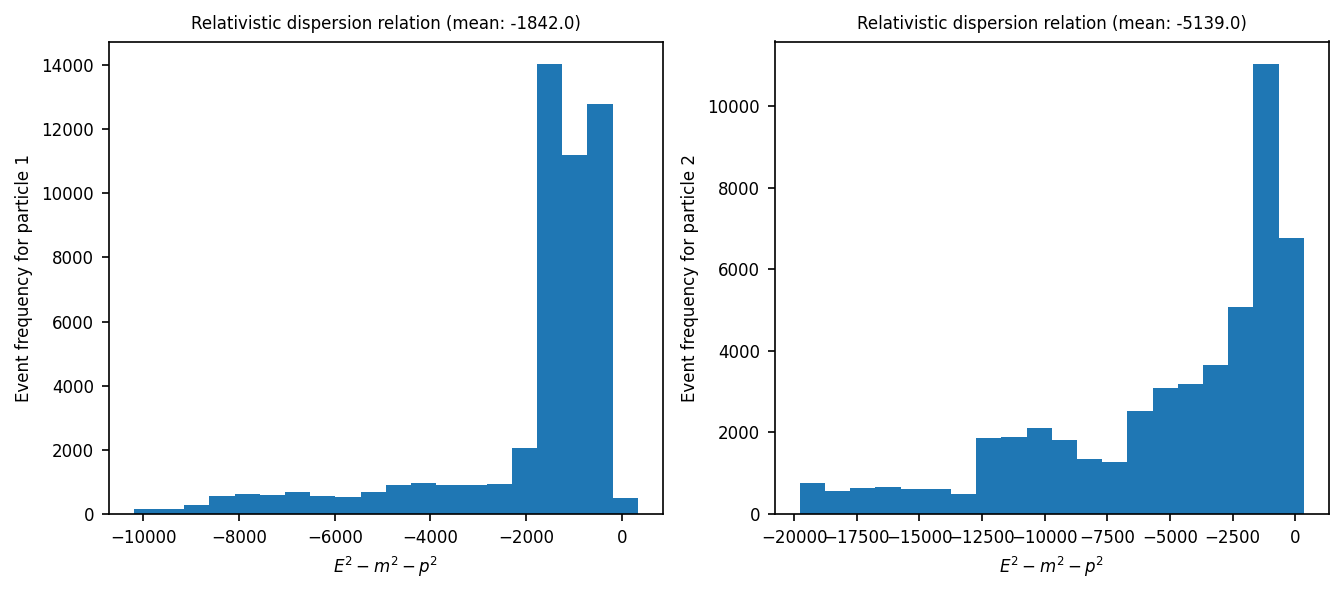

In [75]:
P1 = np.sqrt(X_fake[:, 1]**2 + X_fake[:, 2]**2 + X_fake[:, 3]**2)
P2 = np.sqrt(X_fake[:, 5]**2 + X_fake[:, 6]**2 + X_fake[:, 7]**2)

ax = plt.figure()
plt.subplot(1,2,1)
plt.hist(X_fake[:, 0]**2 - fake_mass[:,0]**2 - P1**2 , bins=20)
plt.title('Relativistic dispersion relation (mean: ' + str(np.round(np.mean(X_fake[:, 0]**2 - fake_mass[:,0]**2 - P1**2))) + ')', fontsize=8);
plt.xlabel('$E^2 - m^2 - p^2$', fontsize=8)
plt.ylabel('Event frequency for particle 1', fontsize=8)

plt.subplot(1,2,2)
plt.hist(X_fake[:, 4]**2 - fake_mass[:, 1]**2 - P2**2, bins=20)
plt.title('Relativistic dispersion relation (mean: ' + str(np.round(np.mean(X_fake[:, 4]**2 - fake_mass[:, 1]**2 - P2**2))) + ')', fontsize=8);
plt.xlabel('$E^2 - m^2 - p^2$', fontsize=8)
plt.ylabel('Event frequency for particle 2', fontsize=8)
plt.tight_layout()

## Compaire Energy histograms

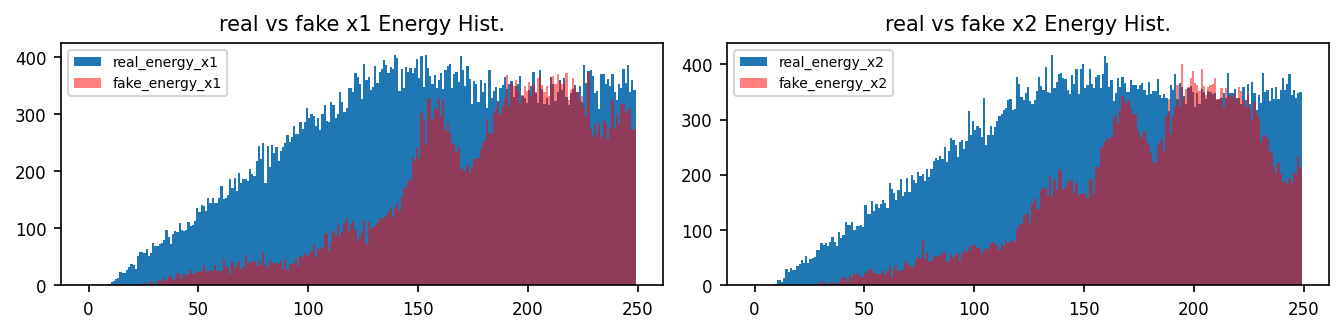

In [83]:
plt.figure()
plt.subplot(2,2,1)
energy_bins = range(250)
x1_real_energy = plt.hist(X_smear[:,0] , bins=energy_bins, label='real_energy_x1')[0]
# plt.title('real x1 Energy Hist.', fontsize=10)
x1_fake_energy = plt.hist(X_fake[:,0] , bins=energy_bins, color='r', alpha=0.5, label='fake_energy_x1')[0]
plt.title('real vs fake x1 Energy Hist.', fontsize=10)
plt.legend(fontsize='small')
plt.subplot(2,2,2)
x2_real_energy = plt.hist(X_smear[:,5] , bins=energy_bins, label='real_energy_x2')[0]
# plt.title('real x2 Energy Hist.', fontsize=10)
x2_fake_energy = plt.hist(X_fake[:,4] , bins=energy_bins, color='r', alpha=0.5, label='fake_energy_x2')[0]
plt.title('real vs fake x2 Energy Hist.', fontsize=10)
plt.legend(fontsize='small')
plt.tight_layout()

## KL divergence as a merit fucntion

In [77]:
def kl_divergence(p, q):
  p = p / np.sum(p)
  q = q / np.sum(q)
  return np.sum(p[i] * np.log2((p[i]+0.001)/(q[i]+0.001)) for i in range(len(p)))

In [78]:
print('x1 real and fake energy KL difference: ' , np.round(kl_divergence(x1_real_energy, x1_fake_energy), 2))
print('x2 real and fake energy KL difference: ' , np.round(kl_divergence(x2_real_energy, x2_fake_energy), 2))

x1 real and fake energy KL difference:  0.14
x2 real and fake energy KL difference:  0.11


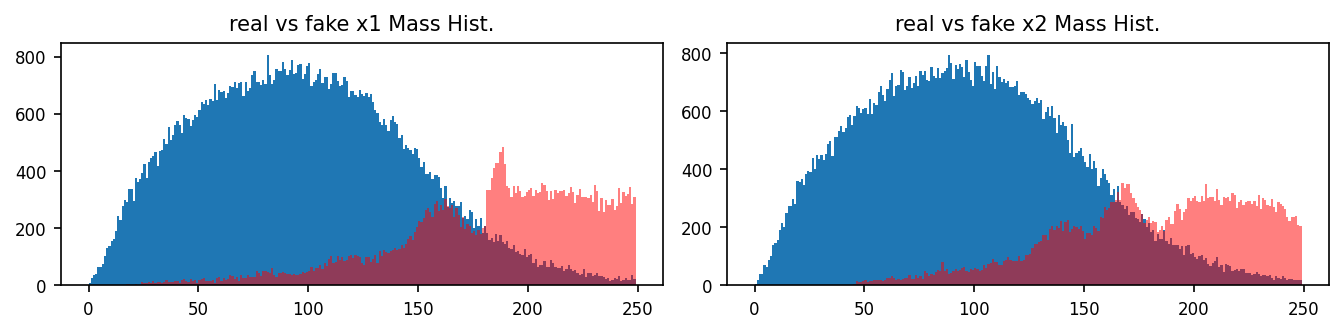

In [79]:
plt.figure()
plt.subplot(2,2,1)
mass_bins = range(250)
x1_real_mass = plt.hist(X_smear[:,4] , bins=mass_bins)[0]
# plt.title('real x1 mass Hist.', fontsize=10)
x1_fake_mass = plt.hist(fake_mass[:,0] , bins=mass_bins, color='r', alpha=0.5)[0]
plt.title('real vs fake x1 Mass Hist.', fontsize=10)

plt.subplot(2,2,2)
x2_real_mass = plt.hist(X_smear[:,9] , bins=mass_bins)[0]
# plt.title('real x2 mass Hist.', fontsize=10)
x2_fake_mass = plt.hist(fake_mass[:,1] , bins=mass_bins, color='r', alpha=0.5)[0]

plt.title('real vs fake x2 Mass Hist.', fontsize=10)
plt.tight_layout()

In [80]:
print('x1 real and fake mass KL difference: ', np.round(kl_divergence(x1_real_mass , x1_fake_mass), 2))
print('x2 real and fake mass KL difference: ',  np.round(kl_divergence(x2_real_mass , x2_fake_mass), 2))

x1 real and fake mass KL difference:  1.26
x2 real and fake mass KL difference:  1.19


# Save fake dataset (VAE dataset)


In [81]:
df = pd.DataFrame(np.concatenate((X_fake,fake_mass),axis=1), columns=['E1', 'p_x1', 'p_y1', 'p_z1',
                                    'E2', 'p_x2', 'p_y2', 'p_z2','m1', 'm2'])

df.insert(0, 'event_id', range(1, 1 + len(df)))
df.to_csv('./fake_generated_dataset_by_VAE.csv', index=False)

# Save/Load the Keras model

In [82]:
import os
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import pickle

if not os.path.exists('./VAE_Model.hdf5'):
  vae.save('./VAE_Model.hdf5', save_format='tf')
  
  with open("scaler_model.pickle", "wb") as file_:
    pickle.dump([sk],file_)

else:
  vae = load_model('./VAE_Model.hdf5')
  with open("./scaler_model.pickle", "rb") as file_:
    sk = pickle.load(file_)

# The end.